# PROJECT: Course Optimization for Data Science
## Optimization strategies for anomaly detection
## with One class Support Vector Machines (OCSVM)

Author: Alexandre Gramfort

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- derive the dual for the one-class SVM model
- implement a one-class SVM using a blackbox convex toolbox (cvxopt in Python)
- implement your own solvers with: Proximal gradient, Coordinate Descent, Quasi-Newton
- Present a clear benchmark of the different strategies on small and medium scale datasets


## VERY IMPORTANT

This work must be done by pairs of students.
Each student must send their work before the 7th of January at 23:59, using the moodle platform.
This means that **each student in the pair sends the same file**

On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called "Project".
This is where you submit your jupyter notebook file.

The name of the file must be constructed as in the next cell

### Gentle reminder: no evaluation if you don't respect this EXACTLY

#### How to construct the name of your file

Some imports

In [3]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt

## Important:

For Part 0 to Part 2 of the project you will need a working install of `cvxopt`.
You may struggle a bit to set it up.
The simplest way of getting it is by typing 

`conda install cvxopt`

or

`pip install cvxopt`

if you have `conda` or `pip` installed on your laptop.
If you **struggle too much please
contact us**.

## Part 0: One-class SVM

The original formulation of the One-Class SVM introduced by Schölkopf [1] is given by

$$
    (\mathcal{P}): \left\{
	\begin{aligned}
	\min_{w, \rho, \xi} & \quad \frac{1}{2}\Vert w \Vert^2 - \rho + \frac{1}{\nu n} \sum_{i=1}^n \xi_i \\
	\text{s.t.} & \quad \langle w, x_i \rangle \geq \rho - \xi_i \quad 1 \leq i \leq n \\
	& \quad \xi_i \geq 0 \quad 1 \leq i \leq n
	\end{aligned}
    \right.
$$

where $\nu \in (0, 1]$ is a user-specified parameter controlling the proportion of outliers and the proportion of support vectors.

Getting rid of the slack variables $\xi_i, 1 \leq i \leq n$ one can also obtain the following equivalent optimization problem

$$
	\min_{w, \rho} \frac{1}{2}\Vert w \Vert^2 - \rho + \frac{1}{\nu n} \sum_{i=1}^n \max(0, \rho - \langle w, x_i \rangle) \, .
$$

The idea is that the lower is $\langle w, x_i \rangle$ is the more $x_i$ is an anomaly and if $\langle w, x_i \rangle \geq \rho$ then the model predicts the sample is normal. $\langle w, x_i \rangle$ corresponds to the decision function and $\textrm{sign}(\langle w, x_i \rangle - \rho)$ as the prediction (1 means normal sample).

[1] Schölkopf et al. Estimating the support of a high-dimensional distribution. Neural Computation. 2001

<div class="alert alert-success">
    <b>QUESTION 1:</b>
     <ul>
      <li>Justify that the problem $(\mathcal{P})$ is convex.</li>
    </ul>
</div>

ANSWER HERE:

Let the function $f$ be
$$f(w, \rho, \xi) = \frac{1}{2}\Vert w \Vert^2 - \rho + \frac{1}{\nu n} \sum_{i=1}^n \xi_i $$

And the set $S$ be

$$S = \{(w,\rho,\xi) \in \mathbb{R}^d \times \mathbb{R} \times \mathbb{R}^n\ :\ \langle w,x_i\rangle \geq \rho - \xi_i,\ \xi_i \geq 0 \ \forall i \in \{1,\ldots,n\} \}$$

Let us prove that $f$ and $S$ are convex.
- $f(\lambda(w_1, \rho_1, \xi^{(1)}) + (1-\lambda)(w_2, \rho_2, \xi^{(2)}) \le \lambda f(w_1, \rho_1, \xi^{(1)}) + (1-\lambda)f(w_2, \rho_2, \xi^{(2)})$  
$ \forall \lambda \in [0,1]$ and $\forall (w_1,\rho_1, \xi^{(1)}), (w_2,\rho_2, \xi^{(2)})$

Let $(w_1,\rho_1, \xi^{(1)}), (w_2,\rho_2, \xi^{(2)}) \in S$ and $\lambda \in [0,1]$
\begin{align*}
f(\lambda (w_1,\rho_1, \xi^{(1)})+ (1-\lambda)(w_2,\rho_2, \xi^{(2)}))&= \frac{1}{2} ||\lambda w_1 + (1-\lambda)w_2||^2 - \lambda \rho_1 - (1-\lambda)\rho_2 + \frac{1}{\nu n} \sum_{i=1}^n(\lambda \xi_i^{(1)} + (1-\lambda)\xi_i^{(2)})\\
&\leq \lambda f(w_1,\rho_1,\xi^{(1)}) + (1-\lambda)f(w_2,\rho_2,\xi^{(2)})
\end{align*}

Since the squared norm function $||\cdot||^2$ is convex.

- $\forall (w_1,\rho_1, \xi^{(1)}), (w_2,\rho_2, \xi^{(2)}) \in S$ and $\forall \lambda \in [0,1],\ (\lambda (w_1,\rho_1, \xi^{(1)})+ (1-\lambda)(w_2,\rho_2, \xi^{(2)})) \in S$

Let $i \in \{1,...,n\}$ and $\lambda \in [0,1]$, we have
\begin{align*}
\langle (\lambda w_1 + (1-\lambda)w_2), x_i\rangle &= \lambda \langle w_1,x_i \rangle + (1-\lambda)\langle w_2,x_i \rangle\\
&\geq \lambda (\rho_1 - \xi_i^{(1)}) + (1-\lambda) (\rho_2 - \xi_i^{(2)})\\
&= (\lambda\rho_1 + (1-\lambda)\rho_2) - (\lambda \xi_i^{(1)}+ (1-\lambda) \xi_i^{(2)})
\end{align*}

And 

$$
\lambda \xi_i^{(1)}+ (1-\lambda) \xi_i^{(2)} \ge 0
$$

Since $\lambda \in [0,1]$ and $\xi_i \ge 0$ for all $i \in \{1, ..., n\}$

Therefore, the function $f$ and the set $S$ are convex. Thus, the problem $(\mathcal{P})$ is convex.

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
      <li>
      By looking at the saddle points of the Lagrangian $\mathcal{L}(w, \rho, \mu)$ of $\mathcal{P}$, $\mu \in \mathbb{R}_+^n$, show that the dual problem $(\mathcal{D})$ can be written as:
$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu
 \\
 \mathrm{s.t.}& \mu^{\top}1_n = 1
 \\
 \mathrm{and}& 0 \leq \mu \leq \frac{1}{\nu n}
 \end{array}
 \right .
$$

with

$$
 G = \begin{bmatrix}x_{1}^{\top} \\ \vdots \\ x_{n}^{\top}\end{bmatrix}
$$

and $1_n = (1, \dots, 1) \in \mathbb{R}^n$.
    </li>
    </ul>
</div>

We will **assume here qualification of the contraints** and that **strong duality holds**.

**Remark:** The problem $(\mathcal{D})$ is a *quadratic program* (QP) for which their exist off-the-shelf techniques. See below.

ANSWER HERE

The lagrangian of problem $(\mathcal{P})$ is $$\mathcal{L}(w,\rho,\xi,\mu,\lambda) = \frac{1}{2}||w||^2-\rho + \frac{1}{\nu n}\sum_{i=1}^n \xi_i + \sum_{i=1}^n\mu_i(\rho-\xi_i-\langle w,x_i\rangle) - \sum_{i=1}^n \lambda_i\xi_i$$ 

with $\mu, \lambda \in \mathbb{R}_+^n$. Since the strong duality holds:

\begin{align*}
(\mathcal{P}) & \Leftrightarrow \min_{w, \rho, \xi} \max_{\mu\geq 0, \lambda\geq0} \mathcal{L}(w,\rho,\xi,\mu, \lambda)\\
&= \max_{\mu \geq 0, \lambda \geq 0} \min_{w, \rho, \xi} \mathcal{L}(w,\rho,\xi,\mu, \lambda)\\
& \Leftrightarrow (\mathcal{D})
\end{align*}

We can re-write $\mathcal{L}$ as
$$\mathcal{L}(w,\rho,\xi,\mu, \lambda)= \rho(\sum_{i=1}^n\mu_i -1)+\sum_{i=1}^n(\tfrac{1}{\nu n}-\mu_i - \lambda_i)\xi_i+\frac{1}{2}||w||^2-\sum_{i=1}^n\mu_i\langle w, x_i\rangle$$

Applying the stationarity condition on $w, \rho, \xi$ from KKT

- $\nabla_w\mathcal{L} = w - \sum_{i=1}^n \mu_i x_i = 0$, then $w = \sum_{i=1}^n \mu_i x_i$
- $\nabla_{\rho}\mathcal{L} = \sum_{i=1}^n \mu_i - 1 = 0$, then $\mu^T 1_n = 1$
- $\nabla_{\xi}\mathcal{L} = \frac{1}{\nu n} - \mu_i - \lambda_i = 0$, then $\mu_i \leq \frac{1}{\nu n}$

Thus, the function $g(\mu)$ to be maximized is:
\begin{align*}
g(\mu) = \min_{w, \rho, \xi} \mathcal{L}(w,\rho,\xi,\mu, \lambda) = \frac{1}{2}||w||^2-\sum_{i=1}^n\mu_i\langle w, x_i\rangle = - \frac{1}{2} ||w||^2 = -\frac{1}{2}\mu^\top GG^\top \mu
\end{align*}

With $\mu^T 1_n = 1$ and $0 \leq \mu \leq \frac{1}{\nu n}$. Since $\max g(\mu) = \min -g(\mu)$. We finally have the dual problem on $\mu$:

$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \displaystyle \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu
 \\
 \mathrm{s.t.}& \mu^{\top}1_n = 1
 \\
 \mathrm{and}& 0 \leq \mu \leq \frac{1}{\nu n}
 \end{array}
 \right .
$$

$$
G = \begin{bmatrix}x_{1}^{\top} \\ \vdots \\ x_{n}^{\top}\end{bmatrix}
$$

and $1_n = (1, \dots, 1) \in \mathbb{R}^n$.

<div class="alert alert-success">
    <b>QUESTION 3:</b>
     <ul>
     <li>Justify that given the estimated $\mu$, the prediction function for a new sample $x$ (-1 if anomaly else 1) is given by:
        $$
        y = \mathrm{sign}(\sum_{i=1}^{n} \mu_i x_i^\top x - \rho) \enspace .
        $$
        The vector $w$ is therefore equal to $\sum_{i=1}^{n} \mu_i x_i$
    </li>
    </ul>
</div>

ANSWER HERE

From the KKT condition on $w$ in the previous question we obtained $w=\sum_{i=1}^n \mu_i x_i$. Replacing this in the prediction function $y = \text{sign}(⟨w,x⟩−ρ)= \text{sign}(w^\top x -\rho)$:

$$y = \text{sign}\left(\sum_{i=1}^n\mu_i x_i^\top x - \rho\right)$$

## Part 1: Implementation of solver using cvxopt

Let's make a toy dataset in dimension 2. When using a linear kernel we need all samples to have positive values and the outliers to be close to the origin.

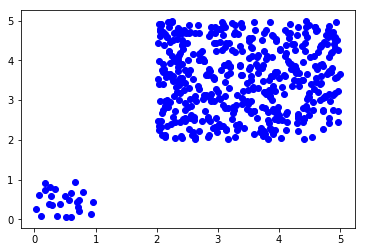

In [4]:
def make_dataset(n_samples, contamination=0.05, random_state=42):
    rng = np.random.RandomState(random_state)
    X_inliers = rng.uniform(low=2, high=5, size=(
        int(n_samples * (1 - contamination)), 2))
    X_outliers = rng.uniform(low=0, high=1, size=(
        int(n_samples * contamination), 2))
    X = np.concatenate((X_inliers, X_outliers), axis=0)
    rng.shuffle(X)
    return X


X = make_dataset(500)
plt.scatter(X[:, 0], X[:, 1], color='b')

- The following function qp allows to solve a quadratic problem of the form:

$$
\left\{
  \begin{array}{cll}
  &\min_{(x)} \frac{1}{2}x^{\top} P x + q^\top x
  \\
   & \textrm{s.t.}\; A x = b, 0 \leq x \leq C.
  \end{array}
  \right.
$$

See documentation: http://cvxopt.org/userguide/coneprog.html#quadratic-programming

In [5]:
import cvxopt


def qp(P, q, A, b, C, verbose=True):
    # Gram matrix
    n = P.shape[0]
    P = cvxopt.matrix(P)
    q = cvxopt.matrix(q)
    A = cvxopt.matrix(A)
    b = cvxopt.matrix(b)
    G = cvxopt.matrix(np.concatenate(
        [np.diag(np.ones(n) * -1), np.diag(np.ones(n))], axis=0))
    h = cvxopt.matrix(np.concatenate([np.zeros(n), C * np.ones(n)]))

    # Solve QP problem
    cvxopt.solvers.options['show_progress'] = verbose
    solution = cvxopt.solvers.qp(P, q, G, h, A, b, solver='mosec')
    return np.ravel(solution['x'])

Definition of the linear kernel:

In [6]:
from sklearn.metrics import pairwise_distances


def kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.dot(X1[i], X2[j])
    return K


def fast_kernel(X1, X2):
    return pairwise_distances(X1, X2, metric=lambda x, y: np.dot(x, y))

**Remark:** You can use `sklearn.metrics.pairwise_distances` to avoid the for loops and make it faster.

<div class="alert alert-success">
    <b>QUESTION 4:</b>
     <ul>
      <li>Modify the following cell to solve the One-Class SVM dual problem.</li>
    </ul>
</div>

In [7]:
# TODO
def ocsvm_solver(K, nu=0.1):
    n = len(K)
    P = K
    q = np.zeros(n)
    A = np.matrix(np.ones(n))
    b = 1.
    C = 1. / (nu * n)
    mu = qp(P, q, A, b, C, verbose=False)
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
    return mu_support, idx_support


K = fast_kernel(X, X)

# Uncomment the following lines when your ocsvm_solver is completed:
mu_support, idx_support = ocsvm_solver(K)
print("Number of support vectors: %s" % idx_support.size)

Number of support vectors: 50


<div class="alert alert-success">
    <b>QUESTION 5:</b>
     <ul>
      <li>Compute w using mu.</li>
    </ul>
</div>

In [8]:
# TODO
w = mu_support.dot(X[idx_support])
w

array([ 1.37631398,  1.37252753])

<div class="alert alert-success">
    <b>QUESTION 6:</b>
     <ul>
      <li>Using complementary slackness, explain how to obtain $\rho$ from $\mu$.</li>
    </ul>
</div>

**HINT:** Use the fact that for all support vectors for which $0 < \mu_i < \frac{1}{\nu n}$ one has $w^{t}x_{i} = \rho$.

ANSWER HERE

In the question we wrote the lagrangian of problem $(\mathcal{P})$: $$\mathcal{L}(w,\rho,\xi,\mu,\lambda) = \frac{1}{2}||w||^2-\rho + \frac{1}{\nu n}\sum_{i=1}^n \xi_i + \sum_{i=1}^n\mu_i(\rho-\xi_i-\langle w,x_i\rangle) - \sum_{i=1}^n \lambda_i\xi_i$$ 

From complementary slackness properties we have the two following conditions:
\begin{align}
\mu_i(\rho-\xi_i-w^\top x_i) &= 0 &(1)\\
\lambda_i\xi_i&=0 &(2)
\end{align}

From the stationarity condition applied on $\xi_i$, we have:
$$
\lambda_i+\mu_i=\frac{1}{\nu n} \quad (3)
$$

From $(1)$ we have that if $\mu_i>0$, then $\rho = w^\top x_i + \xi_i$.
From $(3)$, if $\mu_i < \tfrac{1}{\nu n}$, then $\lambda_i >0$, which implies from $(2)$ that $\xi_i=0$.

We conclude that for all support vectors for which $\mu_i \in (0,\tfrac{1}{\nu n})$, we can obtain the value of $\rho$ as
$$\rho = w^\top x_i$$

In [9]:
# TODO
def compute_rho(K, mu_support, idx_support):
    # TODO
    index = int(np.argmin(mu_support))
    K_support = K[idx_support][:, idx_support]
    rho = mu_support.dot(K_support[index])
    return rho

compute_rho_ = compute_rho(K, mu_support, idx_support)
compute_rho_

6.7570987967128637

<div class="alert alert-success">
    <b>QUESTION 7:</b>
     <ul>
      <li>Verify that you find the same values as what scikit-learn gives. You should have the same support vectors and:


`rho = -ocsvm.intercept_[0] / (ocsvm.nu * len(K))`

and `mu_support = ocsvm.dual_coef_.ravel() / (ocsvm.nu * len(K))`</li>
    </ul>
</div>

In [10]:
from sklearn.utils.testing import assert_array_almost_equal
from sklearn.utils.testing import assert_almost_equal
from sklearn.svm import OneClassSVM

X = make_dataset(150)

ocsvm = OneClassSVM(kernel='linear', nu=0.05)
ocsvm.fit(X)

K = kernel(X, X)
mu_support, idx_support = ocsvm_solver(K, nu=ocsvm.nu)
rho = compute_rho(K, mu_support, idx_support)

# Check indices of support vectors
print(ocsvm.support_)
print(idx_support)

# Check rho
print(rho)
print(-ocsvm.intercept_[0] / (ocsvm.nu * len(K)))

# Check dual variables
print(mu_support)
print(ocsvm.dual_coef_.ravel() / (ocsvm.nu * len(K)))

# Run formal tests:
assert_array_almost_equal(ocsvm.support_, idx_support)
assert_almost_equal(rho, -ocsvm.intercept_[0] / (ocsvm.nu * len(K)))
assert_array_almost_equal(mu_support, ocsvm.dual_coef_.ravel() / (ocsvm.nu * len(K)))

[  4  23  66  72  90  92 109 113]
[  4  23  66  72  90  92 109 113]
2.16400352023
2.16400355501
[ 0.13422819  0.13422819  0.06040268  0.13422819  0.13422819  0.13422819
  0.13422819  0.13422819]
[ 0.13422819  0.13422819  0.06040268  0.13422819  0.13422819  0.13422819
  0.13422819  0.13422819]


Check your code by running the following cell:

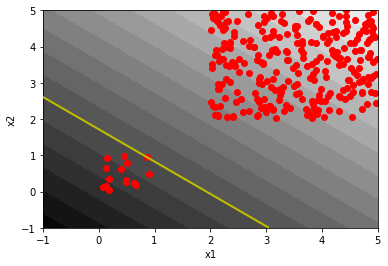

In [11]:
X = make_dataset(300)

K = kernel(X, X)
mu_support, idx_support = ocsvm_solver(K, nu=0.05)
rho = compute_rho(K, mu_support, idx_support)

def plot_ocsvm(X, mu_support, idx_support, rho, kernel=kernel):
    # Compute decision function on a grid
    X1, X2 = np.mgrid[-1:5.1:0.2, -1:5.1:0.2]
    na, nb = X1.shape
    X_test = np.c_[np.reshape(X1, (na * nb, 1)),
                   np.reshape(X2, (na * nb, 1))]

    # Compute dot products
    X_support = X[idx_support]
    G = kernel(X_test, X_support)
    # Compute decision function
    decision = G.dot(mu_support) - rho

    # Compute predict label
    y_pred = np.sign(decision)

    # Plot decision boundary
    plt.plot(X[:,0], X[:, 1], 'or', linewidth=2)
    Z = np.reshape(decision, (na, nb))
    plt.contourf(X1, X2, Z, 20, cmap=plt.cm.gray)
    cs = plt.contour(X1, X2, Z, [0], colors='y', linewidths=2, zorder=10)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim([-1, 5])
    plt.ylim([-1, 5])

plot_ocsvm(X, mu_support, idx_support, rho)

In [12]:
def plot_ocsvm_param(make_dataset=make_dataset, kernel=kernel):
    plt.figure(figsize=(15, 15))
    
    X_sizes = [100, 300, 1000]
    nu_vals = [0.01, 0.05, 0.1]
    
    idx_graph = 1
    for len_x in X_sizes:
        for nu_val in nu_vals: 
            X = make_dataset(len_x)
            K = kernel(X, X)
            mu_support, idx_support = ocsvm_solver(K, nu=nu_val)
            rho = compute_rho(K, mu_support, idx_support)
            
            plt.subplot(3, 3, idx_graph)
            plt.title("n_samples: %d, nu: %.2f" % (len_x, nu_val))
            plot_ocsvm(X, mu_support, idx_support, rho, kernel)

            idx_graph += 1

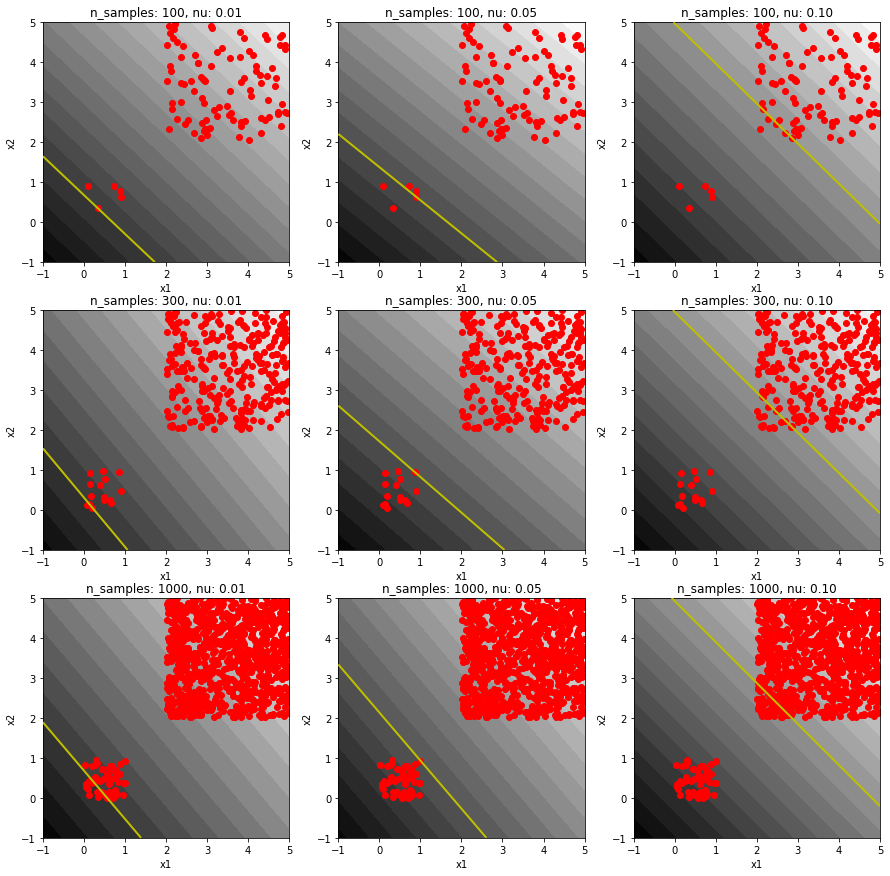

In [13]:
plot_ocsvm_param()

<div class="alert alert-success">
    <b>QUESTION 8:</b>
     <ul>
      <li>Without any implementation, can you justify if you can apply any of the algorithm, among proximal gradient, coordinate descent, stochastic gradient descent and L-BFGS to the dual problem?
      </li>
    </ul>
</div>

ANSWER HERE

These algorithms work if we can rewrite the dual problem as:

$$(\mathcal{D}): \min_{\mu} f(\mu) + g(\mu)$$

where $f$ is here a smooth function of $\mu$ with L-Liptschitz gradient and $g$ may not be a smooth function, but it is separable.

$$g(\mu) = \sum_{i=1}^n g_i(\mu_i)$$

We cannot rewrite the problem in this form beacause of the annoying constraint $\mu^{\top}1_n = 1$. We cannot use methods that follow the gradient direction if we have an equality constraint.

## Part 1: non-linear case with kernels

Another scenario is when the boundary between normal samples and outliers is not linear.

To cope with this the idea is to use kernels.

<div class="alert alert-success">
    <b>QUESTION 9:</b>
     <ul>
      <li>Denoting by $K(x_i, x_j)$ the dot product between samples show that dual problem and the decision function f(x) can be reformulated just using calls to $K$
      </li>
    </ul>
</div>

ANSWER HERE

In the dual problem $\mathcal{D}$ the product $GG^{\top}$ is equal to $K$ since $(GG^{\top})_{i,j} = x_i^{\top}x_j = K(x_i, x_j)$. Thus, $\mathcal{D}$ can be reformulated as 

$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \displaystyle \min_{\mu} &\frac{1}{2}\mu^{\top}K\mu
 \\
 \mathrm{s.t.}& \mu^{\top}1_n = 1
 \\
 \mathrm{and}& 0 \leq \mu \leq \frac{1}{\nu n}
 \end{array}
 \right .
$$

$$
G = \begin{bmatrix}x_{1}^{\top} \\ \vdots \\ x_{n}^{\top}\end{bmatrix}
$$

and $1_n = (1, \dots, 1) \in \mathbb{R}^n$.

The decision function is $f(x) = w^\top x$. As we obtained before $w = \sum_i^n \mu_i x_i$, the decision function can be written like

$$
f(x) = \sum_{i=1}^n \mu_i x_i^\top x
$$


In the question 3 we justified that the prediction function for a new sample $x$ is

$$y = f(x) =  \text{sign}\left(\sum_{i=1}^n \mu_i x_i^\top x - \rho\right)$$

Since $x_i^\top x = K(x_i, x)$, we have:

$$
f(x) =  \text{sign}\left(\sum_{i=1}^n\mu_i K(x_i, x) - \rho\right)
$$
$$
\rho = \sum_{i=1}^n \mu_i K(x_i,x_j)
$$

Where $x_j$ is such that $\mu_j \in (0,\frac{1}{\nu n})$

We will use another dataset to evaluate this:

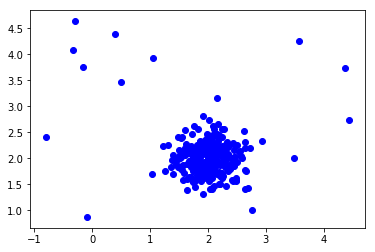

In [14]:
def make_blob_dataset(n_samples, contamination=0.05, random_state=42):
    rng = np.random.RandomState(random_state)
    X_inliers = 0.3 * rng.normal(size=(int(n_samples * (1. - contamination)), 2)) + 2
    X_outliers = rng.uniform(low=-1, high=5, size=(int(n_samples * contamination), 2))
    X = np.concatenate((X_inliers, X_outliers), axis=0)
    rng.shuffle(X)
    return X

X = make_blob_dataset(300)
plt.scatter(X[:, 0], X[:, 1], color='b');

<div class="alert alert-success">
    <b>QUESTION 10:</b>
     <ul>
      <li>Update your kernel function so it computes the Gaussian kernel:
      
        $$
            K(x_i, x_j) = \exp(-\gamma \| x_i - x_j \|^2)
        $$

        where $\gamma > 0$ is the kernel bandwidth.
      </li>
    </ul>
</div>

In [15]:
from scipy import linalg

def _rbf_metric(x, y, gamma=.3):
    return np.exp(-gamma * linalg.norm(x - y, 2)**2)

def rbf_kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    gamma = .3
    for i in range(n1):
        for j in range(n2):
            K[i, j] = _rbf_metric(X1[i], X2[j], gamma)
    return K

def fast_rbf_kernel(X1, X2):
    return pairwise_distances(X1, X2, metric=_rbf_metric)

Using the change above the follwing code should allow you to nicely separate the dense region from the outliers

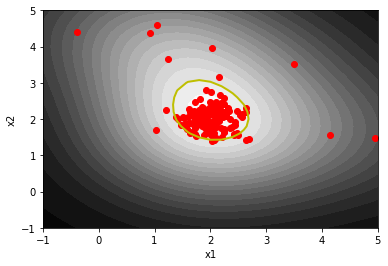

In [16]:
X = make_blob_dataset(160)

K = rbf_kernel(X, X)
mu_support, idx_support = ocsvm_solver(K, nu=0.1)
rho = compute_rho(K, mu_support, idx_support)

plot_ocsvm(X, mu_support, idx_support, rho, kernel=rbf_kernel)

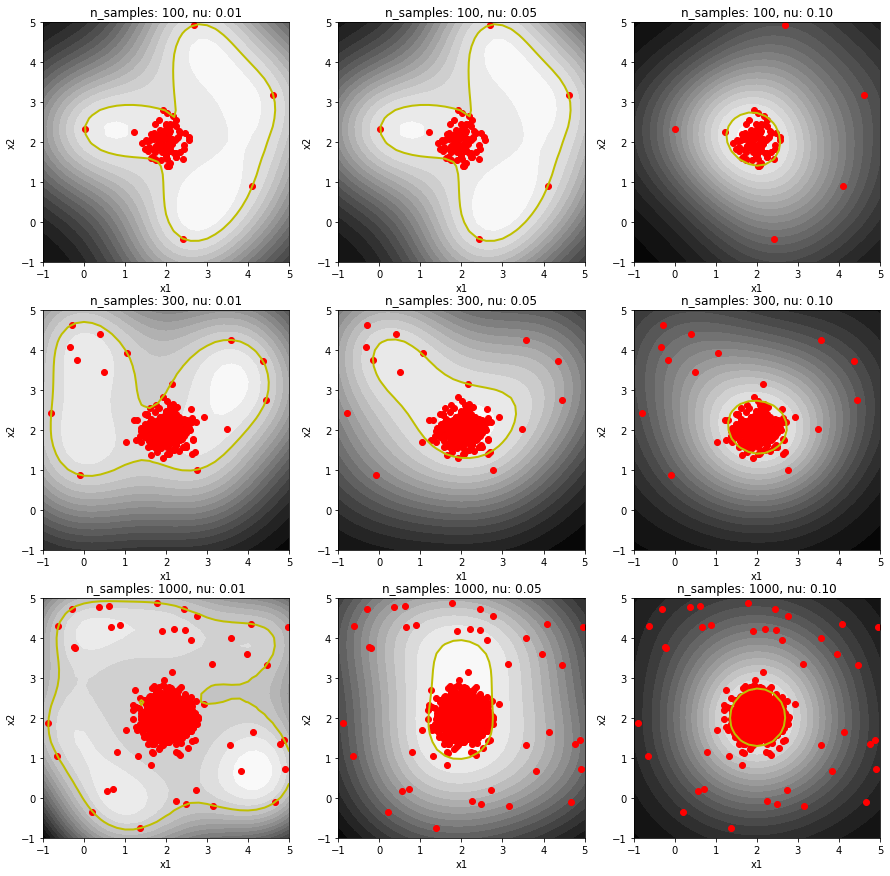

In [17]:
plot_ocsvm_param(make_dataset=make_blob_dataset, kernel=rbf_kernel)

## Part 2: One-class SVM without $\rho$

Formulation for example used in:

```
Consistency of one-class SVM and related algorithms
Régis Vert and Jean-philippe Vert
NIPS 2006
```

The problem of the formuation of SVMs with the variable $\rho$ is that
it leads to an annoying constraint in the dual, namely the $\mu^{\top}1_n = 1$.

We will now see what we can do about it.

Let's consider the problem

$$
	\begin{aligned}
	\min_{w, \xi} & \quad \frac{1}{2}\Vert w \Vert^2 + \frac{C}{n} \sum_{i=1}^n \xi_i \\
	\text{s.t.} & \quad \langle w, x_i \rangle \geq 1 - \xi_i \quad 1 \leq i \leq n \\
	& \quad \xi_i \geq 0 \quad 1 \leq i \leq n
	\end{aligned}
$$

<div class="alert alert-success">
    <b>QUESTION 10:</b>
     <ul>
      <li>Show that a dual problem of this problem is given by:
      
        $$
        (\mathcal{D}):
            \left\{
            \begin{array}{lll}
            \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top} 1_n
            \\
            \mathrm{s.t.}& 0 \leq \mu \leq \frac{C}{n}
            \end{array}
            \right .
        $$
      </li>
    </ul>
</div>

ANSWER HERE

The lagrangian of problem SVM without $\rho$ is
$$\mathcal{L}(w,\xi,\mu,\lambda) = \frac{1}{2}||w||^2 + \frac{C}{n}\sum_{i=1}^n \xi_i + \sum_{i=1}^n\mu_i(1-\xi_i-\langle w,x_i\rangle) - \sum_{i=1}^n \lambda_i\xi_i$$ 

with $\mu, \lambda \in \mathbb{R}_+^n$. Since the strong duality holds:

\begin{align*}
(\mathcal{P}) & \Leftrightarrow \min_{w, \xi} \max_{\mu\geq 0, \lambda\geq0} \mathcal{L}(w,\xi,\mu, \lambda)\\
&= \max_{\mu \geq 0, \lambda \geq 0} \min_{w, \xi} \mathcal{L}(w,\xi,\mu, \lambda)\\
& \Leftrightarrow (\mathcal{D})
\end{align*}

We can re-write $\mathcal{L}$ as
$$\mathcal{L}(w,\xi,\mu, \lambda)=\sum_{i=1}^n \mu_i + \sum_{i=1}^n(\tfrac{C}{n}-\mu_i - \lambda_i)\xi_i+\frac{1}{2}||w||^2-\sum_{i=1}^n\mu_i\langle w, x_i\rangle$$

Applying the stationarity condition on $w, \xi$ from KKT

- $\nabla_w\mathcal{L} = w - \sum_{i=1}^n \mu_i x_i = 0$, then $w = \sum_{i=1}^n \mu_i x_i$
- $\nabla_{\xi}\mathcal{L} = \frac{C}{n} - \mu_i - \lambda_i = 0$, then $\mu_i \leq \frac{C}{n}$

Thus, the function $g(\mu)$ to be maximized is:
\begin{align*}
g(\mu) = \min_{w, \xi} \mathcal{L}(w,\xi,\mu, \lambda) = \frac{1}{2}||w||^2-\sum_{i=1}^n\mu_i\langle w, x_i\rangle + \sum_{i=1}^n \mu_i = - \frac{1}{2} ||w||^2 + \mu^{\top}1_n = -\frac{1}{2}\mu^\top GG^\top \mu + \mu^{\top}1_n
\end{align*}

With $0 \leq \mu \leq \frac{C}{n}$. Since $\max g(\mu) = \min -g(\mu)$. We finally have the dual problem on $\mu$:

$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \displaystyle \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu - \mu^{\top}1_n
 \\
 \mathrm{s.t.}& 0 \leq \mu \leq \frac{C}{n}
 \end{array}
 \right .
$$

$$
G = \begin{bmatrix}x_{1}^{\top} \\ \vdots \\ x_{n}^{\top}\end{bmatrix}
$$

and $1_n = (1, \dots, 1) \in \mathbb{R}^n$.

<div class="alert alert-success">
    <b>QUESTION 11:</b>
     <ul>
      <li> Rewrite the dual in the form:
      
            $$
            (\mathcal{D}): \min_{\mu} f(\mu) + g(\mu) .
            $$

            where $f$ is here a smooth function of $\mu$ with L-Liptschitz gradient and $g$ is a non-smooth function that is separable, namely:

            $$
            g(\mu) = \sum_{i=1}^n g_i(\mu_i)
            $$
      </li>
    </ul>
</div>



ANSWER HERE

We can rewrite the dual in the form:

$$
(\mathcal{D}): \min_{\mu} f(\mu) + g(\mu)
$$

with 

$$
f(\mu) = \frac{1}{2}\mu^{\top}GG^{\top}\mu - \mu^{\top}1_n
$$

$f$ is a smooth function of $\mu$ since it is the sum of a quadratic form $\frac{1}{2}\mu^{\top}GG^{\top}\mu$, which is smooth on $\mu$, with a linear form $- \mu^{\top}1_n$, which is also smooth on $\mu$. Its first derivative on $\mu$ is $\nabla_\mu f = \mu^\top K - 1_n$, where $K$ is the kernel.

For the function $g(\mu)$ we take 

$$
g_i(\mu_i)= 
 \left\{
 \begin{array}{lll}
 \displaystyle 0 & if & 0 \leq \mu_i \leq \frac{C}{n}
 \\
 \infty & otherwise
 \end{array}
 \right .
$$

with 

$$
prox_{g_i}(x) = proj_{\left[0, \frac{C}{n}\right]}(x)
$$

The dual in the later form can be readily optimized using the methods that you have been studying in this class:

- Proximal gradient method with and without acceleration
- L-BFGS-B
- Coordinate descent

<div class="alert alert-success">
    <b>QUESTION 12:</b>
    Implement:
     <ul>
      <li> your own solver based on the QP function in cvxopt (reuse `qp` function above).</li>
      <li> your own solver of proximal gradient with and without acceleration</li>
      <li> your own version of coordinate descent</li>
      <li> an L-BFGS-B solver using `scipy.optimize.fmin_l_bfgs_b`</li>
    </ul>
</div>

You will test your implementations on the Gaussian blob corrupted with some uniform noise obtained with `make_blob_dataset` function.

You will make sure that all solvers converge towards the same minimum !

You will evaluate the performance of your implementations in terms of computation time on problems where the matrix $G G^\top$ can fit in memory on your machine.

You should reuse as much as possible the convergence evaluation code that you used during the labs.

**Remark:** For the coordinate descent method there exist some smart updates provided you use a linear kernel.

**BONUS (Hard):** Explain without implementing it how such smart updates could work for the coordinate descent solver.

**IMPORTANT : This question 12 is the most important and will constitute half of the final grade on the project !**

### Implement your own solver based on the QP function in cvxopt

In [18]:
def qp_solver(K, c=10, verbose=False):
    n = len(K)
    P = cvxopt.matrix(K)
    q = cvxopt.matrix(-1. * np.ones(n))
    C = c / n

    G = cvxopt.matrix(np.concatenate(
        [np.diag(np.ones(n) * -1), np.diag(np.ones(n))], axis=0))
    h = cvxopt.matrix(np.concatenate([np.zeros(n), C * np.ones(n)]))

    # Solve QP problem
    cvxopt.solvers.options['show_progress'] = verbose
    solution = cvxopt.solvers.qp(P, q, G, h, solver='mosec', show_progress=verbose)
    mu = np.ravel(solution['x'])

    # support vectors
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    # mu_support = mu[idx_support]
    return mu, idx_support

In [19]:
# test qp solver
mu_qp, idx_support_qp = qp_solver(K, verbose=True)
w_qp = mu_qp[idx_support_qp].dot(X[idx_support_qp])
print("\nNumber of points on the support vector: %s" % idx_support_qp.size)

     pcost       dcost       gap    pres   dres
 0: -1.4975e+00 -1.3162e+01  5e+02  2e+01  3e-16
 1: -1.0155e+00 -1.2088e+01  3e+01  7e-01  5e-16
 2: -7.2328e-01 -4.0942e+00  3e+00  2e-16  5e-16
 3: -8.9549e-01 -1.5318e+00  6e-01  1e-16  3e-16
 4: -9.2964e-01 -1.3039e+00  4e-01  1e-16  3e-16
 5: -9.5002e-01 -1.1617e+00  2e-01  1e-16  3e-16
 6: -9.6968e-01 -1.0551e+00  9e-02  1e-16  3e-16
 7: -9.8082e-01 -1.0304e+00  5e-02  1e-16  2e-16
 8: -9.9283e-01 -1.0052e+00  1e-02  1e-16  3e-16
 9: -9.9567e-01 -1.0001e+00  4e-03  1e-16  3e-16
10: -9.9650e-01 -9.9842e-01  2e-03  1e-16  3e-16
11: -9.9721e-01 -9.9733e-01  1e-04  1e-16  3e-16
12: -9.9726e-01 -9.9727e-01  6e-06  1e-16  3e-16
13: -9.9727e-01 -9.9727e-01  6e-08  1e-16  3e-16
Optimal solution found.

Number of points on the support vector: 29


#### Lipschitz constants computation:
For 
$$
f(\mu) = \frac{1}{2}\mu^{\top}K\mu - \mu^{\top}1_n
$$

We have $$\nabla f(\mu) = K\mu - 1_n \quad \text{and} \quad \nabla_i f(\mu)=K_{i,:}\mu -1 $$

##### Computing the lipschitz constant L:
$$||\nabla f(\mu)-\nabla f(\omega)||=||K(\mu-\omega)|| \leq \sigma_{\text{max}}(K)||\mu-\omega||
\Rightarrow L=\sigma_{\text{max}}(K)$$

##### Computing the coordinate lipschitz constant L $L_i$:
$$|\nabla_i f(\mu + he_i)-\nabla_if(\mu)|=|K_{i,:}he_i|=K_{i,i}|h| \Rightarrow L_i=K_{i,i}$$

In [21]:
# Class for the SVM dual problem
import scipy.linalg


class SVMDual:

    def __init__(self, n, K, c=1.):
        self.c = c
        self.K = K
        self.n = n

    def f(self, x):
        return 1 / 2. * x.dot(self.K).dot(x) - np.sum(x)

    def loss(self, x):
        return self.f(x) + self.indicator(x)

    def grad_f(self, x):
        return x.dot(self.K) - np.ones(self.n)

    def lipschitz(self):
        return linalg.norm(self.K, 2)

    def lipschitz_i(self, i):
        return self.K[i,i]

    def grad_i(self, x, i):
        return self.K[i].dot(x) - 1.

    def indicator(self, x):
        return np.inf if any((x < 0) | (x > self.c / self.n)) else 0

    def prox_indicator(self, x):
        return np.maximum(0, np.minimum(self.c / self.n, x))

In [22]:
# start "global" parameters
n = X.shape[0]
svm_dual = SVMDual(n, K, c=10.)
svm_step = 1 / svm_dual.lipschitz()
f_min = svm_dual.loss(mu_qp)
x_min = mu_qp

In [23]:
# inspector for iterative methods
import time


def inspector(loss_fun, x_min=x_min, f_min=f_min, n_iter=100, verbose=False):
    """A closure called to update metrics after each iteration."""
    objectives = []
    errors = []
    t0 = time.time()
    it = [0]  # This is a hack to be able to modify 'it' inside the closure.
    timing = []

    def inspector_cl(xk):
        obj = loss_fun(xk) - f_min
        err = scipy.linalg.norm(xk - x_min)
        tim = time.time() - t0
        objectives.append(obj)
        errors.append(err)
        timing.append(tim)
        if verbose == True:
            if it[0] == 0:
                print(' | '.join([name.center(8)
                                  for name in ["it", "obj", "err", "time"]]))
            if it[0] % (n_iter / 5) == 0:
                print(' | '.join([("%d" % it[0]).rjust(8), ("%.2e" % obj).rjust(
                    8), ("%.2e" % err).rjust(8), ("%.4e" % tim).rjust(8)]))
            it[0] += 1
    inspector_cl.obj = objectives
    inspector_cl.err = errors
    inspector_cl.timing = timing

    return inspector_cl

In [24]:
def plot_err_obj(inspectors, logx=False, plot_time=False, suptitle=''):
    plt.figure(figsize=(15, 10 if plot_time else 5))
    
    if suptitle is not '':
        plt.suptitle(suptitle, fontsize=20)

    plt.subplot(2 if plot_time else 1, 2, 1)

    for _, insp in inspectors.items():                
        if not logx:
            plt.semilogy(insp.obj, lw=2)
        else:
            plt.loglog(insp.obj, lw=2)
        plt.title("Loss", fontsize=18)
        plt.xlabel("Epoch", fontsize=14)
        plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)
    plt.legend(list(inspectors.keys()))

    plt.subplot(2 if plot_time else 1, 2, 2)
    for _, insp in inspectors.items():
        if not logx:
            plt.semilogy(insp.err, lw=2)
        else:
            plt.loglog(insp.err, lw=2)
        plt.title("Distance to optimum", fontsize=18)
        plt.xlabel("Epoch", fontsize=14)
        plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)
    
    if plot_time:
        plt.subplot(2, 2, 3)
        for _, insp in inspectors.items():                
            if not logx:
                plt.semilogy(insp.timing, insp.obj, lw=2)
            else:
                plt.loglog(insp.timing, insp.obj, lw=2)
            plt.xlabel("Time", fontsize=14)
            plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)
        plt.legend(list(inspectors.keys()))

        plt.subplot(2, 2, 4)
        for _, insp in inspectors.items():
            if not logx:
                plt.semilogy(insp.timing, insp.err, lw=2)
            else:
                plt.loglog(insp.timing, insp.err, lw=2)
            plt.xlabel("Time", fontsize=14)
            plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)

    plt.legend(list(inspectors.keys()))

### Implement your own solver of proximal gradient with and without acceleration

In [25]:
def ista(x_init, grad, prox_g, n_iter=100, step=1., callback=None):
    """ISTA algorithm"""
    x = x_init.copy()

    for _ in range(n_iter):
        x = prox_g(x - step * grad(x))

        if callback is not None:
            callback(x)
    
    idx_support = np.where(np.abs(x) > 1e-5)[0]
    return x, idx_support

   it    |   obj    |   err    |   time  
       0 | 4.01e-01 | 2.94e-01 | 8.3113e-04
    3000 | 4.54e-07 | 1.80e-03 | 3.1081e-01
    6000 | -2.88e-08 | 4.54e-05 | 5.5961e-01
    9000 | -2.89e-08 | 2.10e-06 | 8.0668e-01
   12000 | -2.89e-08 | 5.20e-07 | 1.0453e+00

Number of points on the support vectors: 29


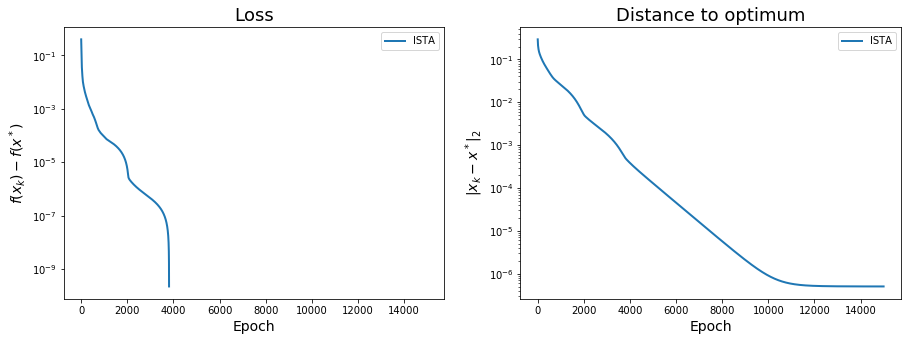

In [32]:
# test insta
n_iter = 15000
ista_inspector = inspector(svm_dual.loss, n_iter=n_iter, verbose=True)
mu_init = np.zeros(n)

mu_ista, idx_support_ista = ista(
    x_init=mu_init,
    grad=svm_dual.grad_f,
    prox_g=svm_dual.prox_indicator,
    n_iter=n_iter,
    step=svm_step,
    callback=ista_inspector
)

w_ista = mu_ista[idx_support_ista].dot(X[idx_support_ista])
print("\nNumber of points on the support vectors: %s" % idx_support_ista.size)
plot_err_obj({'ISTA': ista_inspector})

In [33]:
def fista(x_init, grad, prox_g, n_iter=100, step=1., callback=None):
    """FISTA algorithm"""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.

    for _ in range(n_iter):

        x_new = prox_g(y - step * grad(y))
        t_new = 1 / 2 * (1 + np.sqrt(1 + 4 * t**2))
        y_new = x_new + (t - 1) * (x_new - x) / t_new
        x = x_new
        y = y_new
        t = t_new

        # Update metrics after each iteration.
        if callback is not None:
            callback(x)

    idx_support = np.where(np.abs(x) > 1e-5)[0]
    return x, idx_support

   it    |   obj    |   err    |   time  
       0 | 4.01e-01 | 2.94e-01 | 1.0340e-03
     600 | -2.59e-08 | 1.43e-04 | 7.4036e-02
    1200 | -2.89e-08 | 2.16e-05 | 1.4273e-01
    1800 | -2.89e-08 | 7.49e-06 | 2.3699e-01
    2400 | -2.89e-08 | 5.44e-06 | 3.0866e-01

Number of points on the support vectors: 29


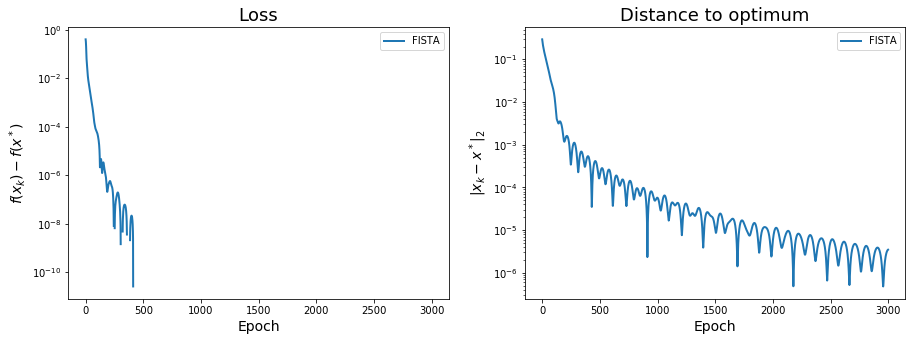

In [37]:
n_iter = 3000
fista_inspector = inspector(svm_dual.loss, n_iter=n_iter, verbose=True)
mu_init = np.zeros(n)

mu_fista, idx_support_fista = fista(
    x_init=mu_init,
    grad=svm_dual.grad_f,
    prox_g=svm_dual.prox_indicator,
    n_iter=n_iter,
    step=svm_step,
    callback=fista_inspector
)

w_fista = mu_fista[idx_support_fista].dot(X[idx_support_fista])
print("\nNumber of points on the support vectors: %s" % idx_support_fista.size)
plot_err_obj({'FISTA': fista_inspector})

### Implement your own version of coordinate descent

In [38]:
def cd(x_init, grad_i, prox_g, steps, n_iter=50, callback=None):
    x = x_init.copy()
    x_new = x_init.copy()
    n_features = len(x)

    for k in range(n_iter + 1):
        i = k % n_features
        x[i] = prox_g(x[i] - grad_i(x, i) * steps[i])

        # Update metrics after each iteration.
        if callback is not None and (k % len(x_init) == 0) :
            callback(x)

    idx_support = np.where(np.abs(x) > 1e-5)[0]
    return x, idx_support

   it    |   obj    |   err    |   time  
       0 | 9.37e-01 | 3.26e-01 | 1.4200e-03

Number of points on the support vectors: 29


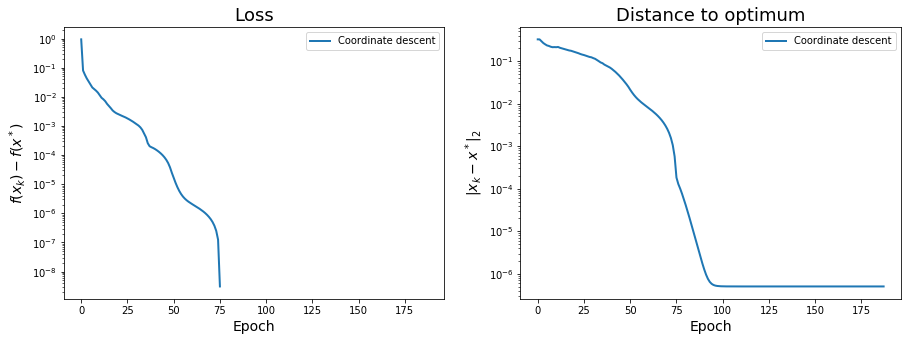

In [41]:
n_iter = 30000
data_pass = int(n_iter/n)
cd_inspector = inspector(svm_dual.loss, n_iter=data_pass, verbose=True)
mu_init = np.zeros(n)

steps = [1. / svm_dual.lipschitz_i(i) for i in range(n)]

mu_cd, idx_support_cd = cd(
    x_init=mu_init,
    grad_i=svm_dual.grad_i,
    prox_g=svm_dual.prox_indicator,
    steps=steps,
    n_iter=n_iter,
    callback=cd_inspector
)

w_cd = mu_cd[idx_support_cd].dot(X[idx_support_cd])
print("\nNumber of points on the support vectors: %s" % idx_support_cd.size)
plot_err_obj({'Coordinate descent': cd_inspector})

### Implement an L-BFGS-B solver using `scipy.optimize.fmin_l_bfgs_b`

In [42]:
from scipy.optimize import fmin_l_bfgs_b


def fmin_l_bfgs_b_svm(x_init, loss, grad, bounds, maxiter=100, callback=None):
    x, _, _ = fmin_l_bfgs_b(
        loss, x_init, grad, maxiter=maxiter, bounds=bounds, callback=callback, epsilon=1e-10)
    idx_support = np.where(np.abs(x) > 1e-5)[0]
    return x, idx_support

   it    |   obj    |   err    |   time  
       0 | 4.00e-01 | 2.94e-01 | 1.8580e-03
      20 | 1.76e-03 | 7.63e-02 | 5.6579e-03
      40 | 1.85e-05 | 5.32e-03 | 9.6030e-03

Number of points on the support vectors: 29


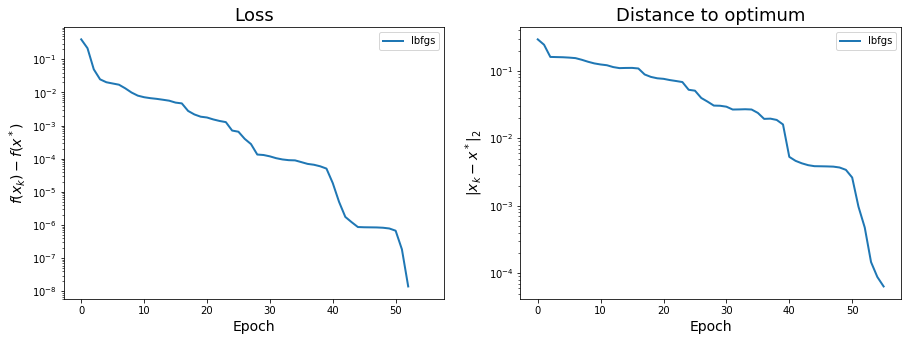

In [44]:
n_iter = 100
lbfgs_inspector = inspector(svm_dual.loss, n_iter=n_iter, verbose=True)

mu_init = np.zeros(n)
bounds = [(0, svm_dual.c / svm_dual.n) for _ in range(n)]

mu_lbfgs, idx_support_lbfgs = fmin_l_bfgs_b_svm(
    x_init=mu_init,
    loss=svm_dual.f,
    grad=svm_dual.grad_f,
    bounds=bounds,
    maxiter=n_iter,
    callback=lbfgs_inspector
)

w_lbfgs = mu_lbfgs[idx_support_lbfgs].dot(X[idx_support_lbfgs])
print("\nNumber of points on the support vectors: %s" % idx_support_lbfgs.size)
plot_err_obj({'lbfgs': lbfgs_inspector})

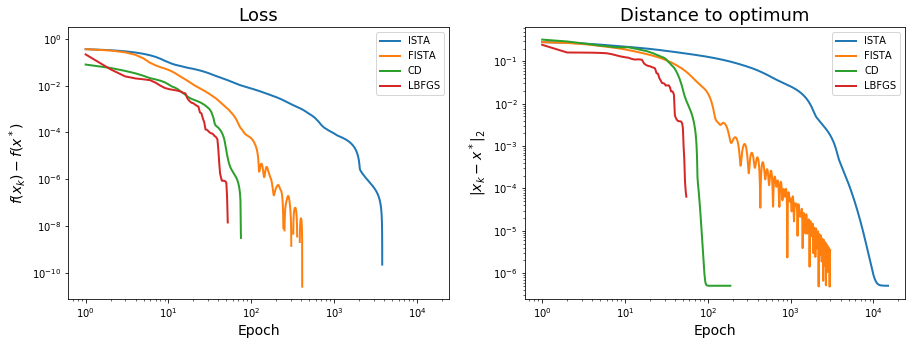

In [47]:
# plotting all methods together
inspectors = {
    'ISTA': ista_inspector,
    'FISTA': fista_inspector,
    'CD': cd_inspector,
    'LBFGS': lbfgs_inspector
}
plot_err_obj(inspectors, logx=True)

Computation time analyse below

### Verify that all the methods converge toweards the same minimum

In [48]:
import pandas as pd

def _round(x):
    return float("%.4f" % x)

def _map2list(w):
    return list(map(_round, w))

w_data = [
    ['cvxopt qp', _map2list(w_qp)],
    ['ISTA', _map2list(w_ista)],
    ['FISTA', _map2list(w_fista)],
    ['Coordinate Descent', _map2list(w_cd)],
    ['LBFGS', _map2list(w_lbfgs)]
]

w_df = pd.DataFrame(w_data, columns=['Solver', 'Value'])
w_df

,Solver,Value
0,cvxopt qp,"[3.4031, 3.9568]"
1,ISTA,"[3.4032, 3.9568]"
2,FISTA,"[3.4032, 3.9568]"
3,Coordinate Descent,"[3.4032, 3.9568]"
4,LBFGS,"[3.4032, 3.9568]"


### Evaluate the performance of your implementation in terms of computation time on problems where the matrix can fit in memory on your machine.

In [52]:
def plot_perf(X_size):
    X = make_blob_dataset(X_size)
    K = rbf_kernel(X, X)

    print('Running cvxopt qp...')
    mu_qp, idx_support_qp = qp_solver(K)

    # start "global" parameters
    n = X.shape[0]
    svm_dual = SVMDual(n, K, c=10.)
    svm_step = 1 / svm_dual.lipschitz()
    f_min = svm_dual.loss(mu_qp)
    x_min = mu_qp
    n_iter = 10000
    mu_init = np.zeros(n)

    print('Running ISTA...')
    ista_inspector = inspector(svm_dual.loss, x_min, f_min, n_iter)
    mu_ista, idx_support_ista = ista(
        x_init=mu_init,
        grad=svm_dual.grad_f,
        prox_g=svm_dual.prox_indicator,
        n_iter=n_iter,
        step=svm_step,
        callback=ista_inspector
    )

    print('Running FISTA...')
    fista_inspector = inspector(svm_dual.loss, x_min, f_min, n_iter)
    mu_fista, idx_support_fista = fista(
        x_init=mu_init,
        grad=svm_dual.grad_f,
        prox_g=svm_dual.prox_indicator,
        n_iter=n_iter,
        step=svm_step,
        callback=fista_inspector
    )

    cd_inspector = inspector(svm_dual.loss, x_min, f_min, n_iter=n_iter)
    steps = [1. / svm_dual.lipschitz_i(i) for i in range(n)]

    print('Running Coordinate descent...')
    mu_cd, idx_support_cd = cd(
        x_init=mu_init,
        grad_i=svm_dual.grad_i,
        prox_g=svm_dual.prox_indicator,
        steps=steps,
        n_iter=n_iter * n,
        callback=cd_inspector
    )

    print('Running LBFGS...')
    lbfgs_inspector = inspector(svm_dual.loss, x_min, f_min, n_iter)
    bounds = [(0, svm_dual.c / svm_dual.n) for _ in range(n)]
    mu_lbfgs, idx_support_lbfgs = fmin_l_bfgs_b_svm(
        x_init=mu_init,
        loss=svm_dual.f,
        grad=svm_dual.grad_f,
        bounds=bounds,
        maxiter=n_iter,
        callback=lbfgs_inspector
    )

    inspectors = {
        'ISTA': ista_inspector,
        'FISTA': fista_inspector,
        'CD': cd_inspector,
        'LBFGS': lbfgs_inspector
    }

    suptitle = "Number of samples: %d" % X_size
    plot_err_obj(inspectors, logx=True, plot_time=True, suptitle=suptitle)

Running cvxopt qp...
Running ISTA...
Running FISTA...
Running Coordinate descent...
Running LBFGS...


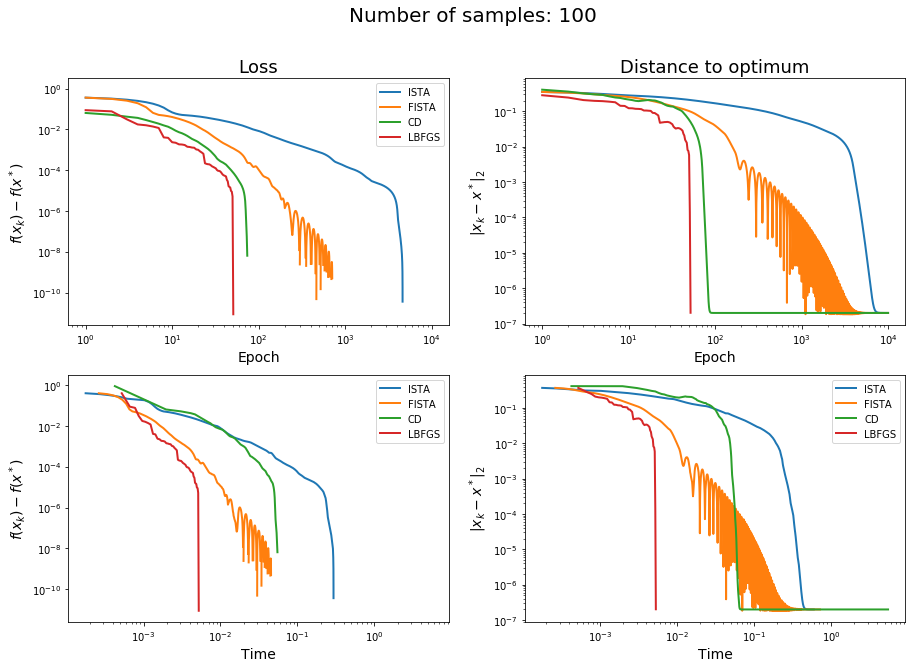

In [53]:
X_sizes = [100, 300, 1000]
plot_perf(X_sizes[0])

Running cvxopt qp...
Running ISTA...
Running FISTA...
Running Coordinate descent...
Running LBFGS...


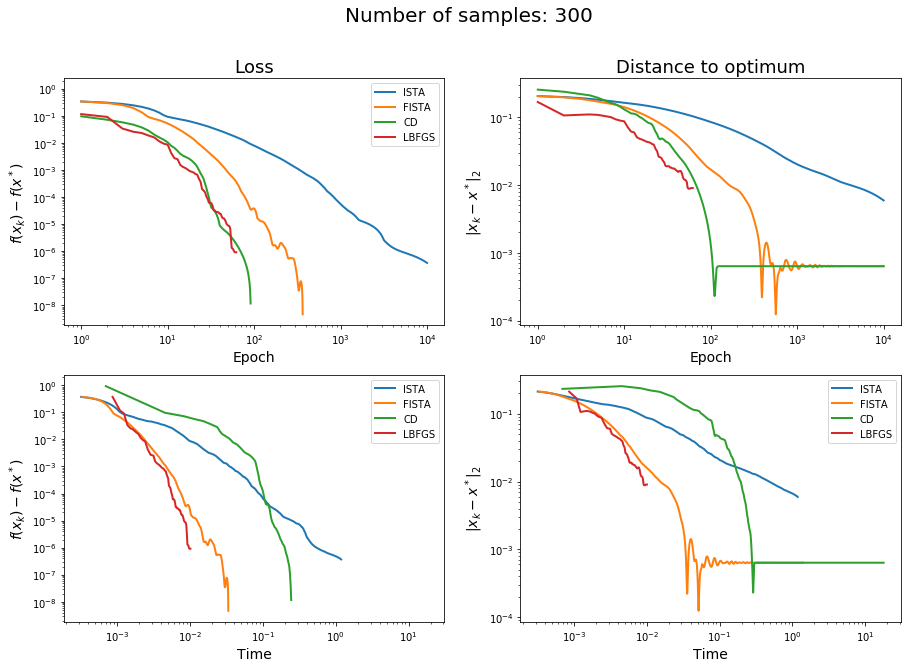

In [54]:
plot_perf(X_sizes[1])

Running cvxopt qp...
Running ISTA...
Running FISTA...
Running Coordinate descent...
Running LBFGS...


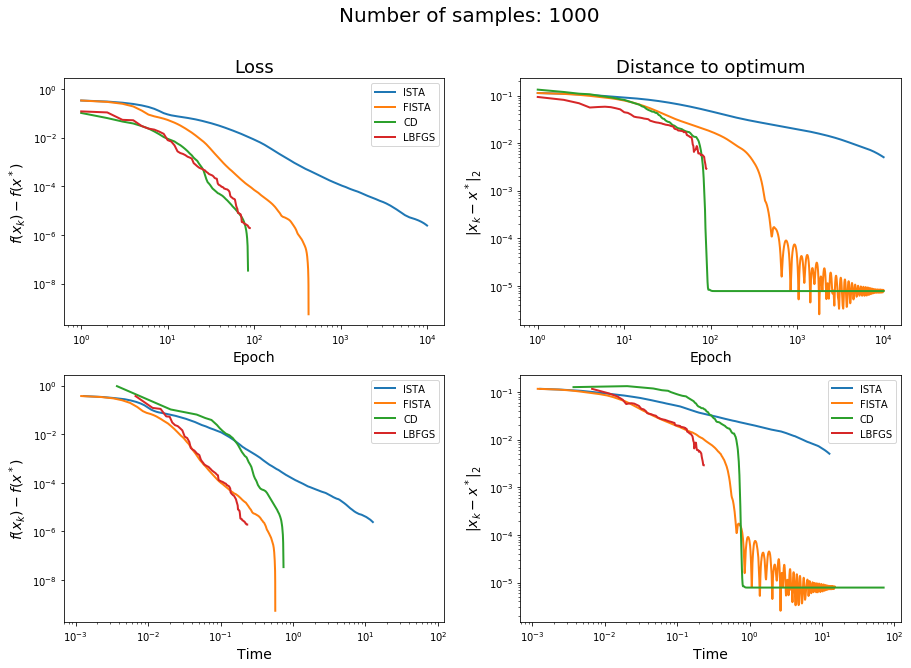

In [55]:
plot_perf(X_sizes[2])

### Conclusions

### Comparing in terms of iterations
For CD, one epoch actually means $n$ iterations so we divided the number of iteration by $n$ to be able to compare on one 
figure the algorithms more easily.

ISTA rate of convergence is $f(x_k)-f(x^*) = O(\frac{1}{n_{iter}})$

FISTA rate of convergence is $f(x_k)-f(x^*) = O(\frac{1}{n_{iter}^2})$

ISTA needs 10 times more iterations to achieve the same precision as FISTA for 100 samples and 100 times more iterations for 1000 samples, which is coherent with expected results.

The iteration of L-BFGS-S cost a lot (full gradient to compute and other operations) but are much more effective with only 70 iterations to reach $10^{-7}$ precision for 100 samples and 100 iterations for 1000 samples, which is around 5 times less than FISTA

Coordinate descent needs a lot more iterations than the others because it optimizes along only one coordinate at a time, but if we compare epochs the number of epochs for coordinate descent is more or less the same as LBFGS.

### Comparing in terms of time
ISTA is definitely much slower than other algorithms.

We can observe that LBFGS and FISTA are comparable in term of time to achieve a given precision, independently of the number of samples. However, coordinate descent is almost 10 times slower than them for 100 samples but almost as fast as them for 1000 samples. This can be explained by the fact that LBFGS and FISTA needs to compute the full gradient at each iteration while coordinate descent only has a partial gradient to compute. When the number of samples grows, the cost of each iteration increases a lot more for LBFGS and FISTA than for coordinate descent.